In [1]:
# Import our basic tools
import pandas as pd  # For handling data tables
print("Pandas loaded successfully! 🐼")

# Check if we have the other tools we'll need later
try:
    import matplotlib.pyplot as plt
    from sklearn.feature_extraction.text import TfidfVectorizer
    print("All tools loaded successfully! 🧰")
except:
    print("We're missing some tools - don't worry, we'll install them later if needed.")

Pandas loaded successfully! 🐼
All tools loaded successfully! 🧰


In [2]:
#Load the Data
try:
    complaints = pd.read_csv('complaints_processed.csv')
    print("Data loaded successfully! 📊")
    print(f"We have {len(complaints)} complaints to analyze!")
    print("\nFirst 3 complaints preview:")
    display(complaints.head(3))  # Show a small sample
except Exception as e:
    print("Oops! Problem loading data: 😞")
    print(str(e))
    print("\nLet me help you fix this!")

Data loaded successfully! 📊
We have 162421 complaints to analyze!

First 3 complaints preview:


,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...


In [4]:
print("Here are all the columns in our data:")
print(list(complaints.columns))

Here are all the columns in our data:
['Unnamed: 0', 'product', 'narrative']


In [5]:
print("🔍 Revised Data Health Check:")

# 1. Check for missing values
print("\n1. Missing values per column:")
print(complaints.isnull().sum())

# 2. Product types overview 
print("\n2. Product types distribution:")
print(complaints['product'].value_counts(dropna=False))

# 3. Sample narratives
print("\n3. Sample complaint narratives:")
print(complaints['narrative'].head(3))

🔍 Revised Data Health Check:

1. Missing values per column:
Unnamed: 0     0
product        0
narrative     10
dtype: int64

2. Product types distribution:
product
credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: count, dtype: int64

3. Sample complaint narratives:
0    purchase order day shipping amount receive pro...
1    forwarded message date tue subject please inve...
2    forwarded message cc sent friday pdt subject f...
Name: narrative, dtype: object


In [6]:
#Handling Missing Narratives
# Drop rows with missing narratives 
clean_data = complaints.dropna(subset=['narrative']).copy()
print(f"Removed {len(complaints)-len(clean_data)} rows with missing narratives")

Removed 10 rows with missing narratives


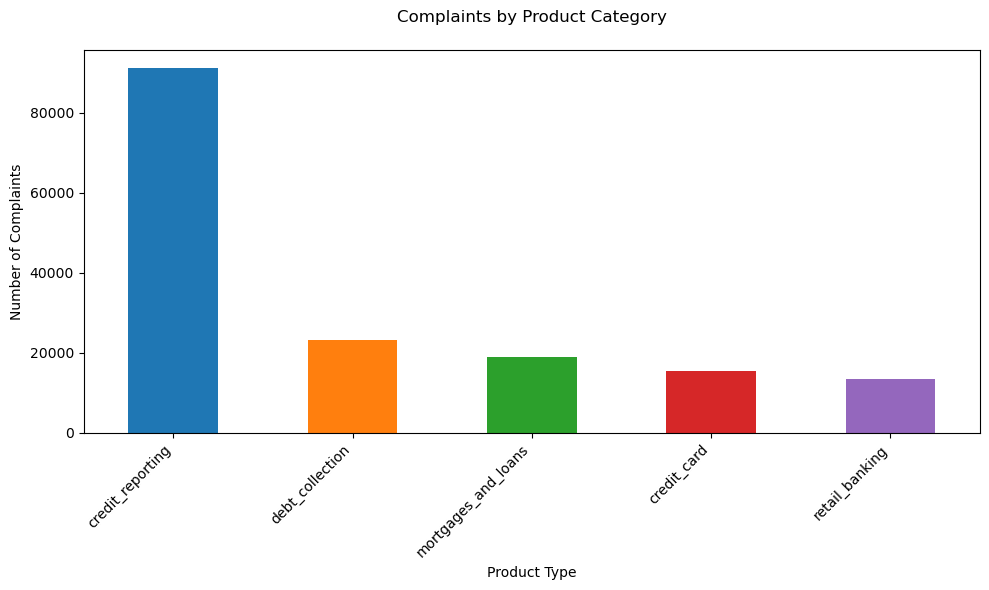

In [7]:
#Analyzing Product Distribution
# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
clean_data['product'].value_counts().plot(kind='bar', 
                                        color=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd'])
plt.title("Complaints by Product Category", pad=20)
plt.xlabel("Product Type")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
#Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning 
clean_data['clean_text'] = clean_data['narrative'].apply(clean_text)
print("Text cleaning completed!")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/86b2da4d-83af-4465-b042-
[nltk_data]     e544970e5684/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text cleaning completed!


In [9]:
# Final Data Check
print("\n🔍 Final Data Summary:")
print(f"Total complaints: {len(clean_data)}")
print("\nSample cleaned text:")
print(clean_data['clean_text'].head(3))


🔍 Final Data Summary:
Total complaints: 162411

Sample cleaned text:
0    purchase order day shipping amount receive pro...
1    forwarded message date tue subject please inve...
2    forwarded message cc sent friday pdt subject f...
Name: clean_text, dtype: object


In [10]:
#Prepare Data for Training
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Split into features (X) and target (y)
X = clean_data['clean_text']  # Our cleaned complaint text
y = clean_data['product']     # The product categories we want to predict

# 2. Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Using top 5000 words
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Data prepared for training!")
print(f"Training samples: {X_train_tfidf.shape[0]}")
print(f"Testing samples: {X_test_tfidf.shape[0]}")
print(f"Number of features: {X_train_tfidf.shape[1]}")

Data prepared for training!
Training samples: 129928
Testing samples: 32483
Number of features: 5000


In [11]:
#Train a Classification Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Initialize and train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# 2. Make predictions on test set
y_pred = model.predict(X_test_tfidf)

# 3. Evaluate performance
print("\nModel Evaluation:")
print(classification_report(y_test, y_pred, target_names=y.unique()))


Model Evaluation:
                     precision    recall  f1-score   support

        credit_card       0.79      0.77      0.78      3132
     retail_banking       0.90      0.94      0.92     18283
   credit_reporting       0.81      0.72      0.76      4615
mortgages_and_loans       0.86      0.82      0.84      3770
    debt_collection       0.87      0.89      0.88      2683

           accuracy                           0.87     32483
          macro avg       0.85      0.83      0.84     32483
       weighted avg       0.87      0.87      0.87     32483



In [12]:
#Save the Model
import joblib

# Save the model and vectorizer
joblib.dump(model, 'complaint_classifier.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

print("Model saved for future use!")

Model saved for future use!


In [13]:
#Create a Demo
ef predict_complaint_type(new_complaint):
    cleaned = clean_text(new_complaint)
    vectorized = tfidf.transform([cleaned])
    return model.predict(vectorized)[0]

# Test with a new complaint
test_complaint = "The credit bureau reported incorrect information on my credit score"
print(f"Predicted category: {predict_complaint_type(test_complaint)}")

Predicted category: credit_reporting
